## 資料清洗
### note:訓練集的製備是模型訓練效能最重要的步驟之一
## 安裝與導入套件

In [1]:
import os
import time
import numpy as np
import IPython.display as display
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import tensorflow as tf

# 讀取dataset 路徑

In [2]:
# create a dataset of the file paths
dataset_path = './data_NEU/*'
list_ds = tf.data.Dataset.list_files(str(dataset_path))
# demo
for f in list_ds.take(5):
    print(f.numpy())
print(list_ds)

b'./data_NEU/PS_163.bmp'
b'./data_NEU/RS_159.bmp'
b'./data_NEU/Sc_187.bmp'
b'./data_NEU/PS_136.bmp'
b'./data_NEU/PS_100.bmp'
<DatasetV1Adapter shapes: (), types: tf.string>


# 定義相關參數

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

train_size = int(0.6 * DATASET_SIZE)
val_size = int(0.2 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)

classes = ['In', 'Cr', 'Pa', 'PS', 'RS', 'Sc']
CLASS_NAMES = np.array(['Inclusion', 'Crazing', 'Patches',
                        'Pitted surface', 'Rolled-in scale', 'Scratches'])

# 資料清洗
## 透過tensorflow image 能對影像進行簡單的前處理
### 以下舉例些常用的方法：
* 剪裁影像的中心區塊
* 調整影像對比
* 調整影響亮度
* 影像水平翻轉

更多方法請參見:https://www.tensorflow.org/api_docs/python/tf/image

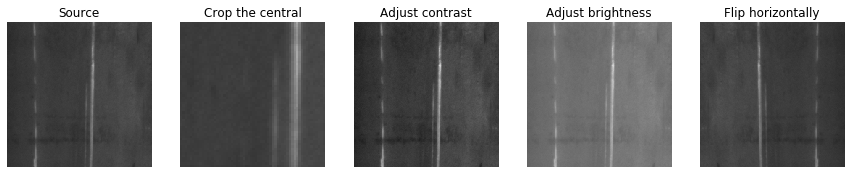

In [4]:
path = './data_NEU/Sc_198.bmp'

img = tf.io.read_file(path)
img = tf.image.decode_bmp(img)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.grayscale_to_rgb(img)

# Crop the central region of the image
img_crop = tf.image.central_crop(img, 0.3)
# Adjust contrast
img_contrast = tf.image.adjust_contrast(img, 1.5)
# Adjust the brightness
img_brightness = tf.image.adjust_brightness(img, delta=0.2)
# Flip an image horizontally (left to right)
img_flip = tf.image.flip_left_right(img)

# show image
img_all = [img, img_crop, img_contrast, img_brightness, img_flip]
img_title = ['Source','Crop the central','Adjust contrast','Adjust brightness','Flip horizontally']
plt.figure(figsize=(15,15))
for i in range(len(img_all)):    
    plt.subplot(1,5,i+1)
    plt.imshow(img_all[i])
    plt.axis('off')
    plt.title(img_title[i])    

# Histogram equalization
* 利用影像直方圖對對比度進行調整
* 這種方法對於背景和前景都太亮或者太暗的影像非常有用
* 能夠讓影像呈現出更好的細節

<img src="img/Histogrammeinebnung.png" width="75%" height="75%" align=left/>

圖片來源:https://commons.wikimedia.org/w/index.php?curid=668605

In [5]:
def tf_equalize_histogram(image):
    image = tf.image.rgb_to_grayscale(image)*255
    values_range = tf.constant([0., 255.], dtype = tf.float32)
    histogram = tf.histogram_fixed_width(tf.dtypes.cast(image, tf.float32), values_range, 256)
    cdf = tf.cumsum(histogram)
    cdf_min = cdf[tf.reduce_min(tf.where(tf.greater(cdf, 0)))]

    img_shape = tf.shape(image)
    pix_cnt = img_shape[-3] * img_shape[-2]
    px_map = tf.round(tf.dtypes.cast((cdf - cdf_min), tf.float32) * 255. / tf.dtypes.cast((pix_cnt - 1), tf.float32))
    px_map = tf.cast(px_map, tf.uint8)
    eq_hist = tf.expand_dims(tf.gather_nd(px_map, tf.cast(image, tf.int32)), 2)
    eq_hist = tf.image.grayscale_to_rgb(eq_hist)
    return eq_hist

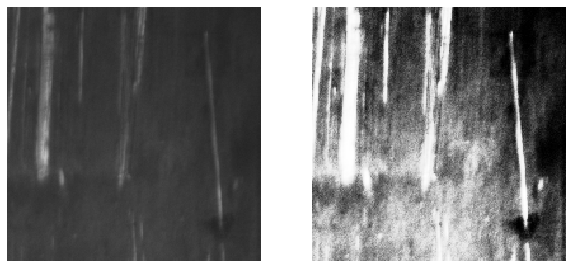

In [6]:
for path in list_ds.take(5): 
    img = tf.io.read_file(path)
    img = tf.image.decode_bmp(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.grayscale_to_rgb(img)
    img_he = tf_equalize_histogram(img)

    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off') 
    plt.subplot(1,2,2)
    plt.imshow(img_he)
    plt.axis('off')
    plt.show()
    
    time.sleep(2)
    display.clear_output(wait=True)

# 取得資料標記

In [8]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # path e.g.'../dataset/NEU-CLS/Cr_235.bmp'
    parts = tf.strings.split(parts[-1], '_')[0]
    return parts == classes

In [9]:
print(get_label('./data_NEU/Cr_235.bmp'))

tf.Tensor([False  True False False False False], shape=(6,), dtype=bool)


# 影像前處理
1. 將影像轉換成Tensor格式
2. 使用histogram equalization調整影像
3. 將影像縮小

In [10]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_bmp(img)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range
    img = tf.image.convert_image_dtype(img, tf.float32)    
    # image grayscale to rgb
    img = tf.image.grayscale_to_rgb(img)
    # histogram equalization
    img = tf_equalize_histogram(img)  
    # resize the image to the desired size
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])   
    return img

# 透過Dataset.map創建資料集和標籤

In [11]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [12]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [13]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True False False False False]


### 訓練集分配
1. 打散資料集
2. 分配出train、validation、test，3個資料集
3. 資料集劃分批次

#### train/validation/test (6:2:2)

- train:用作訓練模型
- validation:更新模型參數
- test:最終模型效能測試

<img src="img/dataset.JPG" width="75%" height="75%" align="left"/>

In [14]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
            
    #Randomly shuffles the elements of this dataset.
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    train_dataset = ds.take(train_size)
    test_dataset = ds.skip(train_size)
    val_dataset = test_dataset.skip(test_size)
    test_dataset = test_dataset.take(test_size)    
    
    train_dataset = train_dataset.batch(BATCH_SIZE)
    val_dataset = val_dataset.batch(BATCH_SIZE)
    
    # `prefetch` lets the dataset fetch batches in the background while the model is training.
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) 
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) 
    
    return train_dataset, val_dataset, test_dataset

In [15]:
train_ds, val_ds, test_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))

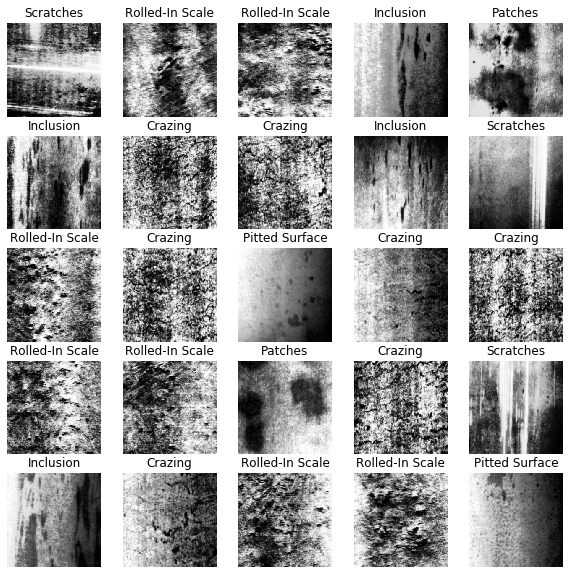

In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n]/255)
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
show_batch(image_batch.numpy(), label_batch.numpy())

# 資料標註(Labeling)
* 乏味且耗時耗人力的一種工作，但它又非常的重要
* 透過標記工具能增加標註的效率

## 標註工具

#### LabelImg:https://github.com/tzutalin/labelImg
- LabelImg為desktop版本的labeling工具，安裝及使用非常簡便
- 目前有Linux及Windows兩種版本
- 支援VOC及YOLO兩種標識格式

<img src="img/LabelImg.JPG" alt="architecture" width="50%" height="50%" />

#### VoTT:https://github.com/Microsoft/VoTT
- 微軟的開源工具，
- 可以標註影片、圖片
- 支援多種標識格式(VOC、JSON、TFRecord、CSV等)

<img src="img/VOTT.JPG" alt="architecture" width="50%" height="50%" />


# 讀取標註資料

* 以VOC為例讀取xml檔案
* 提取需要的資料
* 畫出bounding box

In [17]:
img_path = 'img/patches_35.jpg' 
label_path = 'img/patches_35.xml'

tree = ET.parse(label_path)
root = tree.getroot()
xml_list = []
for member in root.findall('object'):
    value = (root.find('filename').text,
             int(root.find('size')[0].text),
             int(root.find('size')[1].text),
             member[0].text,
             int(member[4][0].text),
             int(member[4][1].text),
             int(member[4][2].text),
             int(member[4][3].text)
             )
    xml_list.append(value)
print(xml_list)

[('patches_35.jpg', 200, 200, 'patches', 44, 2, 93, 60), ('patches_35.jpg', 200, 200, 'patches', 141, 29, 183, 73), ('patches_35.jpg', 200, 200, 'patches', 51, 109, 100, 199)]


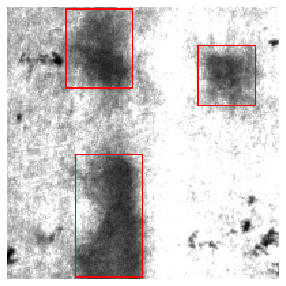

In [18]:
img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img)
img = tf.image.convert_image_dtype(img, tf.float32)

bbox = []
for item in xml_list:
    bbox.append([item[5]/item[2], item[4]/item[1], item[7]/item[2], item[6]/item[1]])    
bbox = tf.constant([bbox],dtype=tf.float32)

image_with_box = tf.image.draw_bounding_boxes(tf.expand_dims(img,0),bbox, colors=[[1,0,0]])
plt.figure(figsize=(5,5))
plt.imshow(image_with_box[0])
plt.axis('off')
plt.show()